### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Feb 16 06:37:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.3/112.6 GB disk)


In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets





!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="M82qLvUrd8JPN8jcsvBm")
project = rf.workspace("caries-tnyeb").project("caries-etskl")
version = project.version(2)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Caries-2 in yolov11:: 100%|██████████| 47628/47628 [00:13<00:00, 3492.98it/s]


## Custom Training

In [5]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 19.7M/19.7M [00:00<00:00, 225MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/datasets/Caries-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, a

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [6]:
!ls {HOME}/runs/segment/train/

args.yaml					    labels.jpg	      train_batch2.jpg
BoxF1_curve.png					    MaskF1_curve.png  val_batch0_labels.jpg
BoxP_curve.png					    MaskP_curve.png   val_batch0_pred.jpg
BoxPR_curve.png					    MaskPR_curve.png  val_batch1_labels.jpg
BoxR_curve.png					    MaskR_curve.png   val_batch1_pred.jpg
confusion_matrix_normalized.png			    results.csv       val_batch2_labels.jpg
confusion_matrix.png				    results.png       val_batch2_pred.jpg
events.out.tfevents.1739688095.a14f51dad190.2150.0  train_batch0.jpg  weights
labels_correlogram.jpg				    train_batch1.jpg


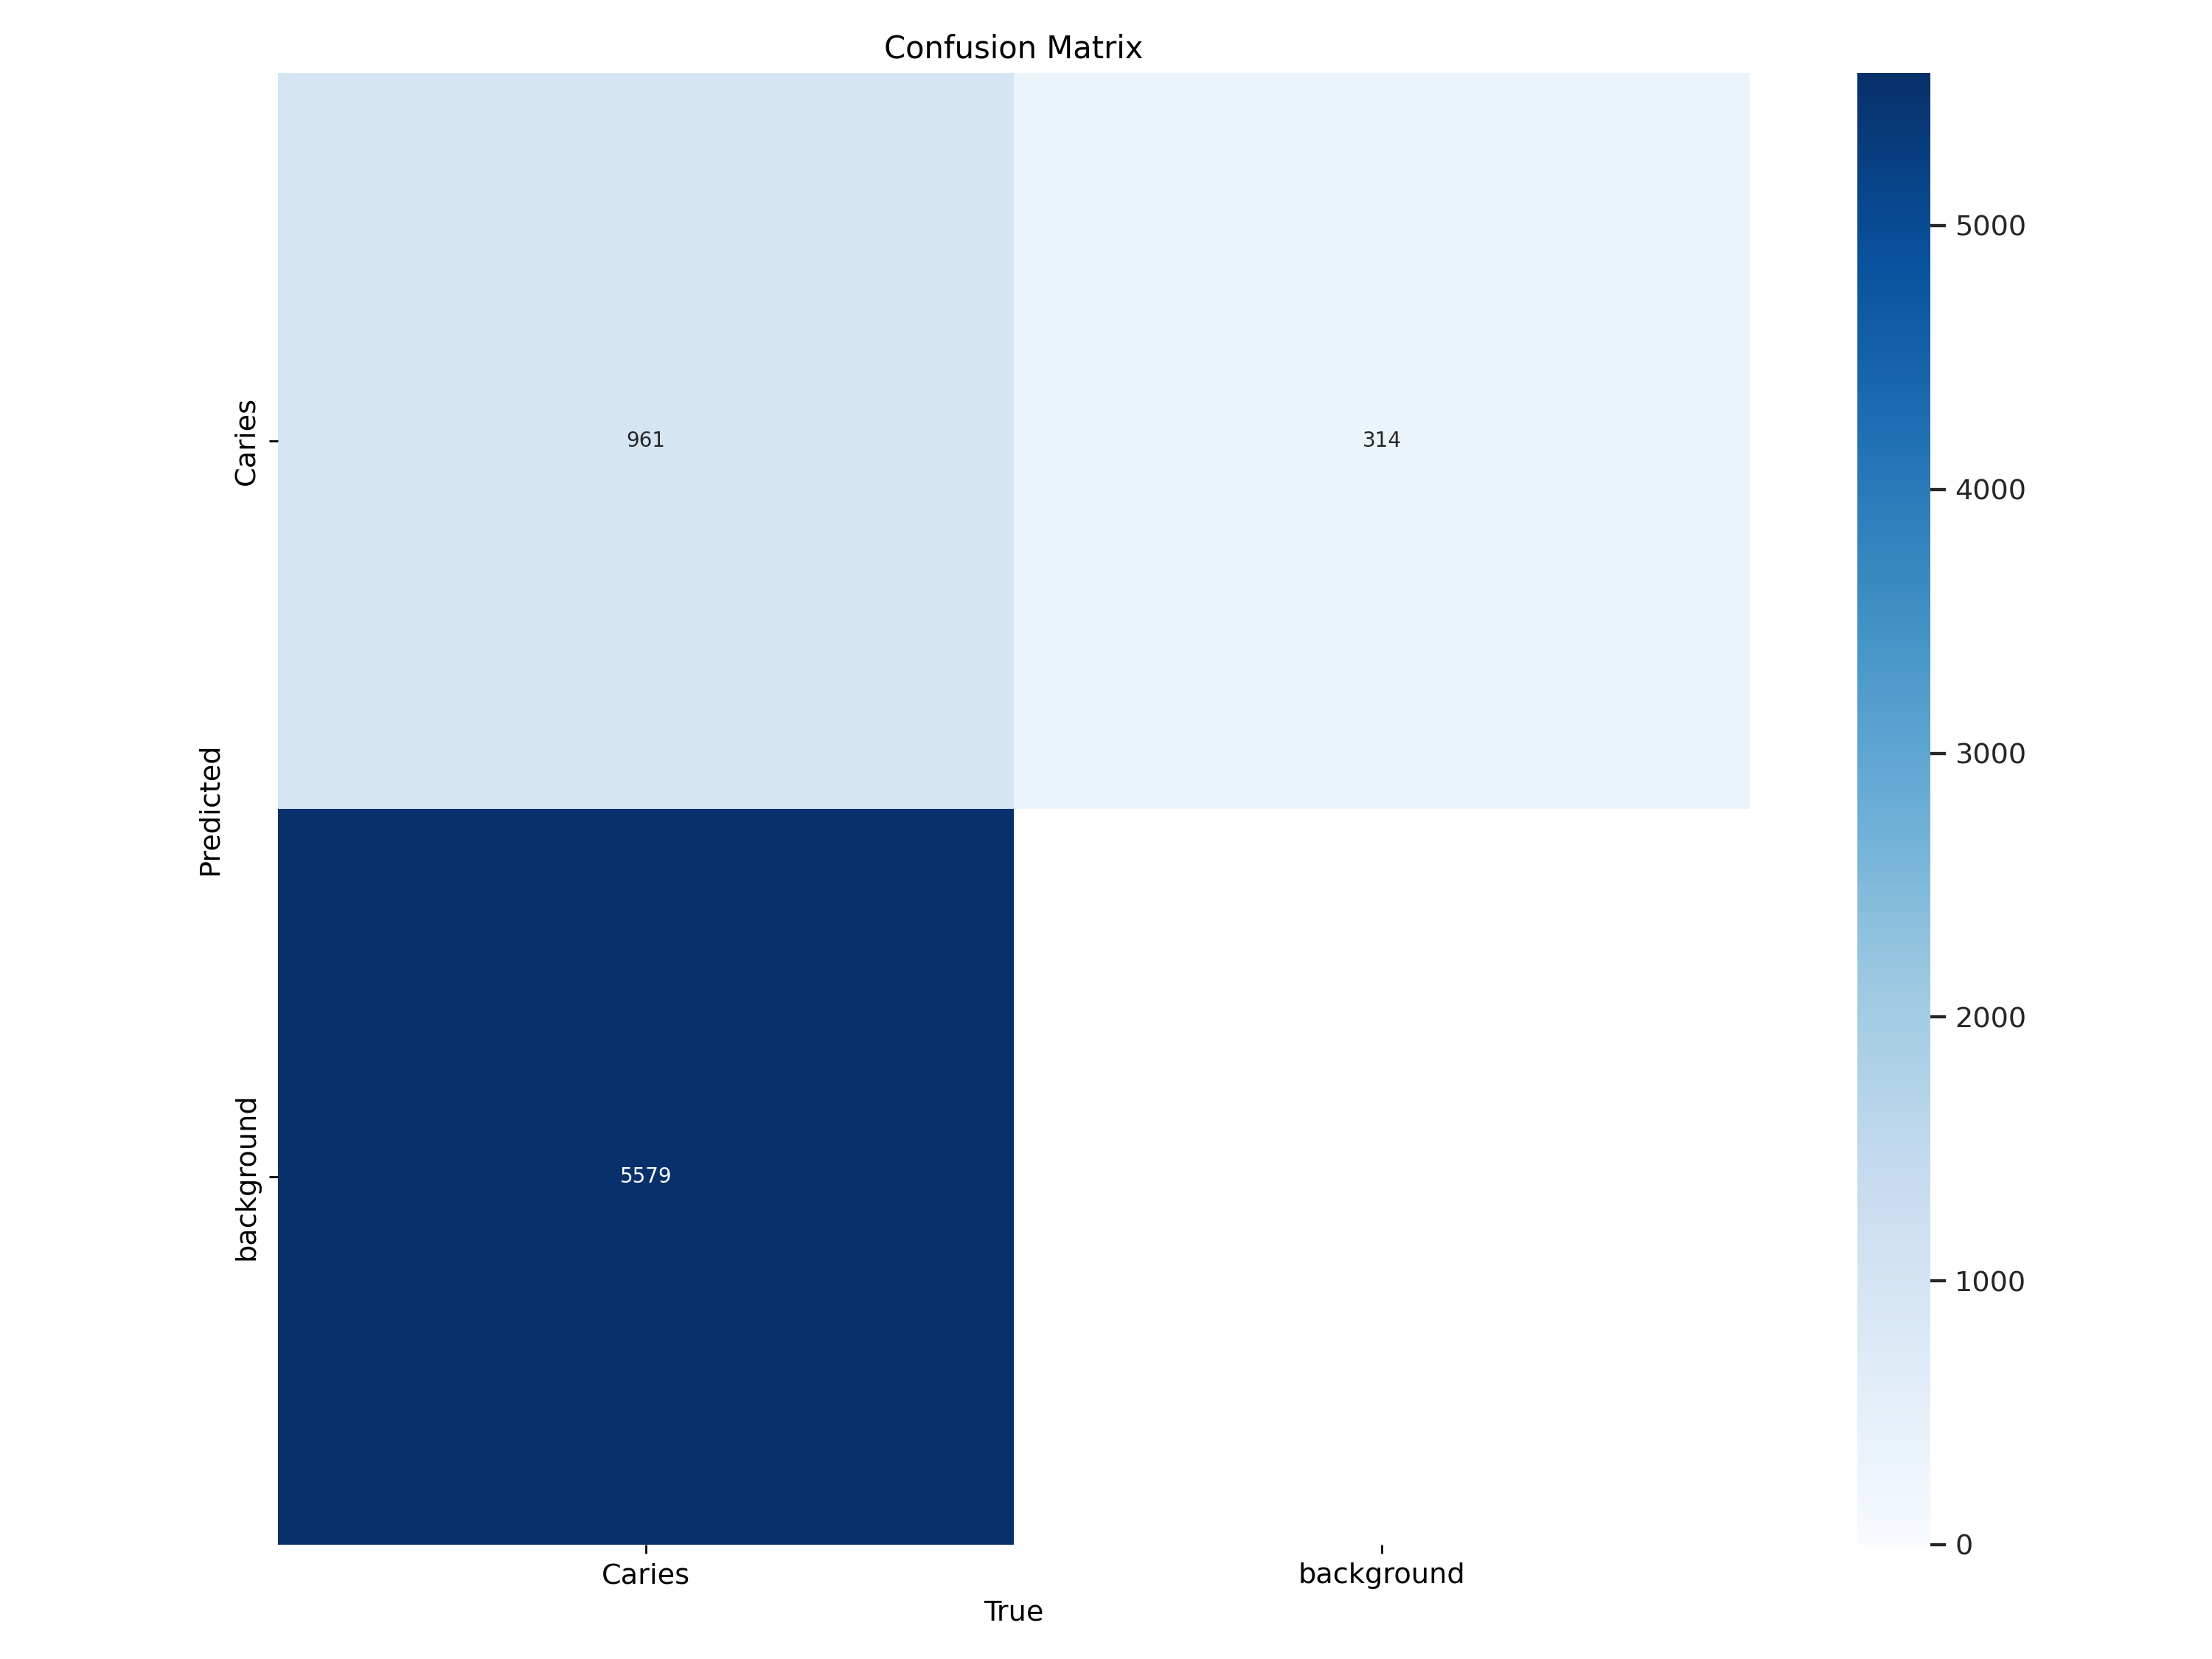

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

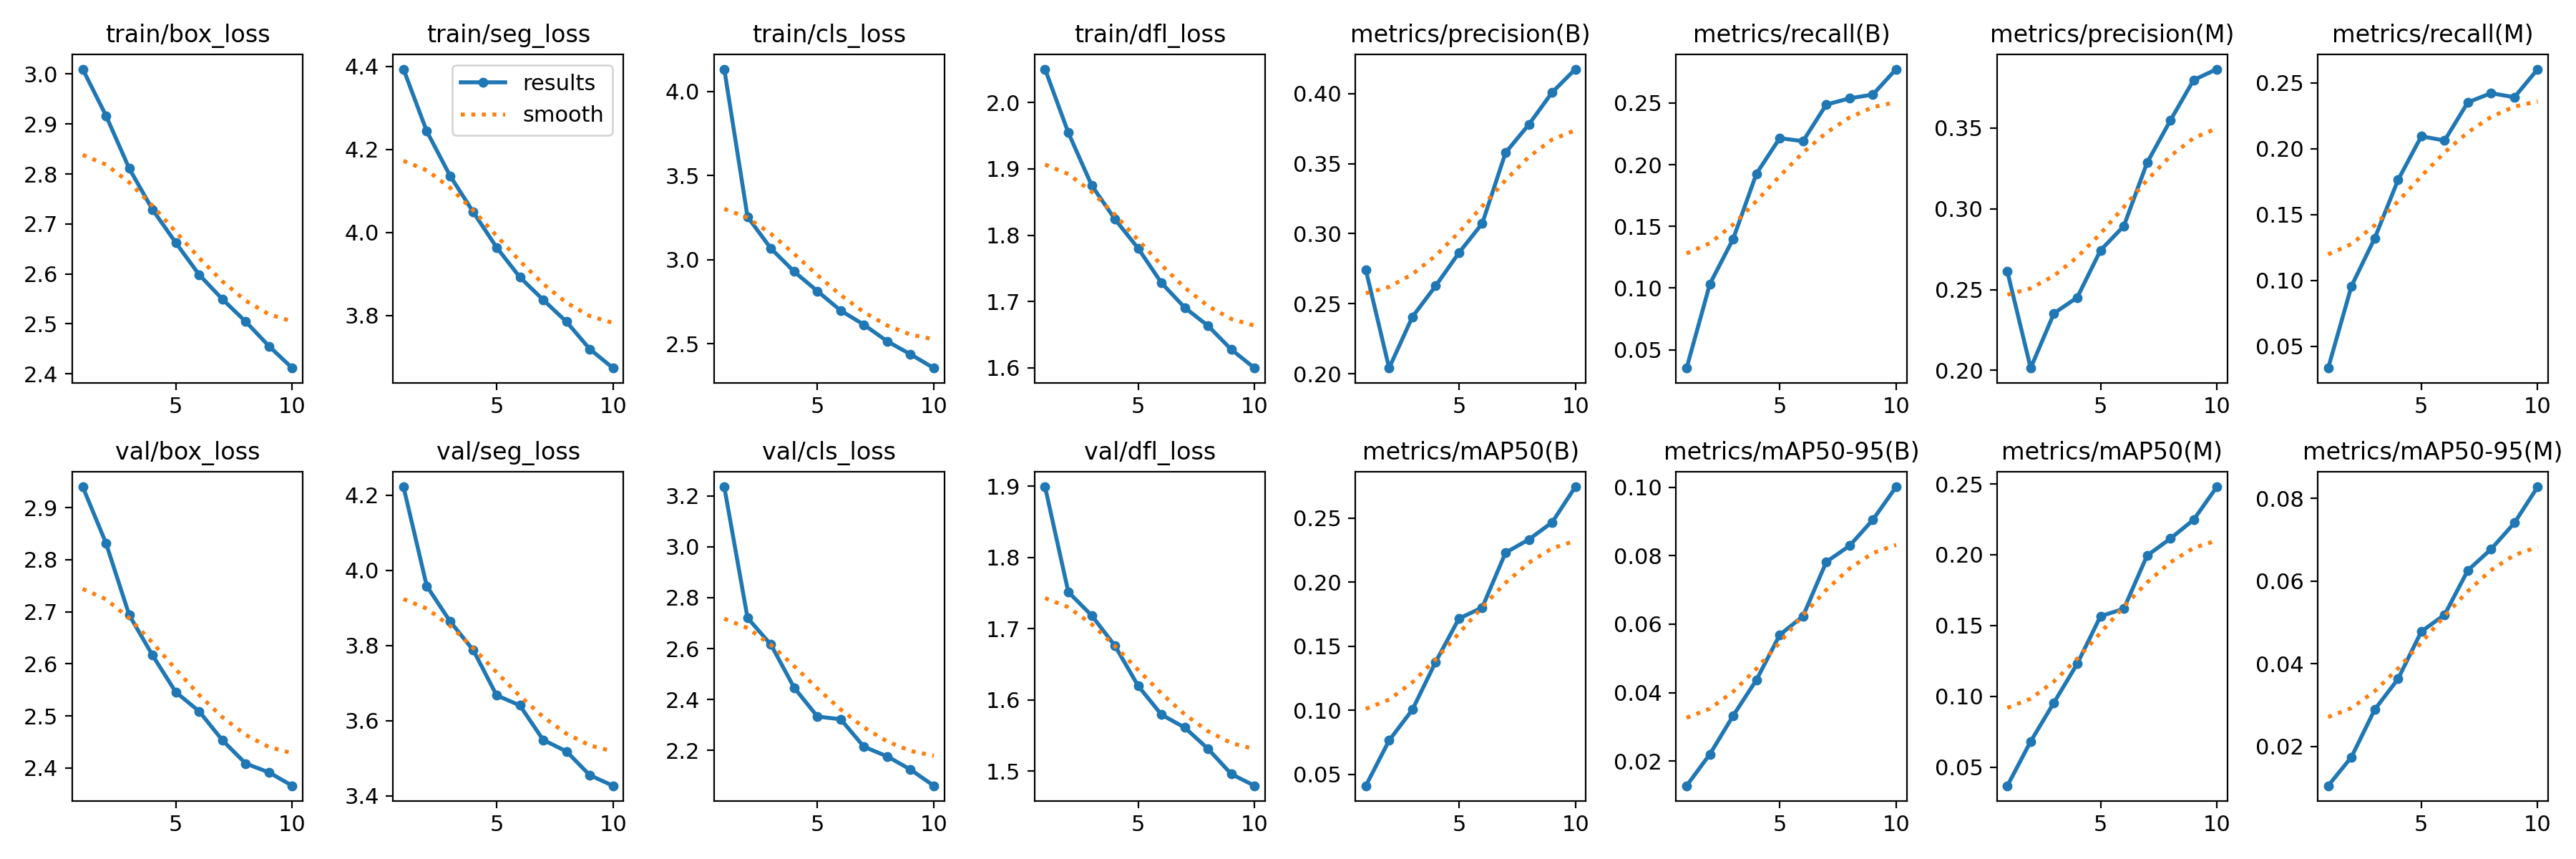

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=600)

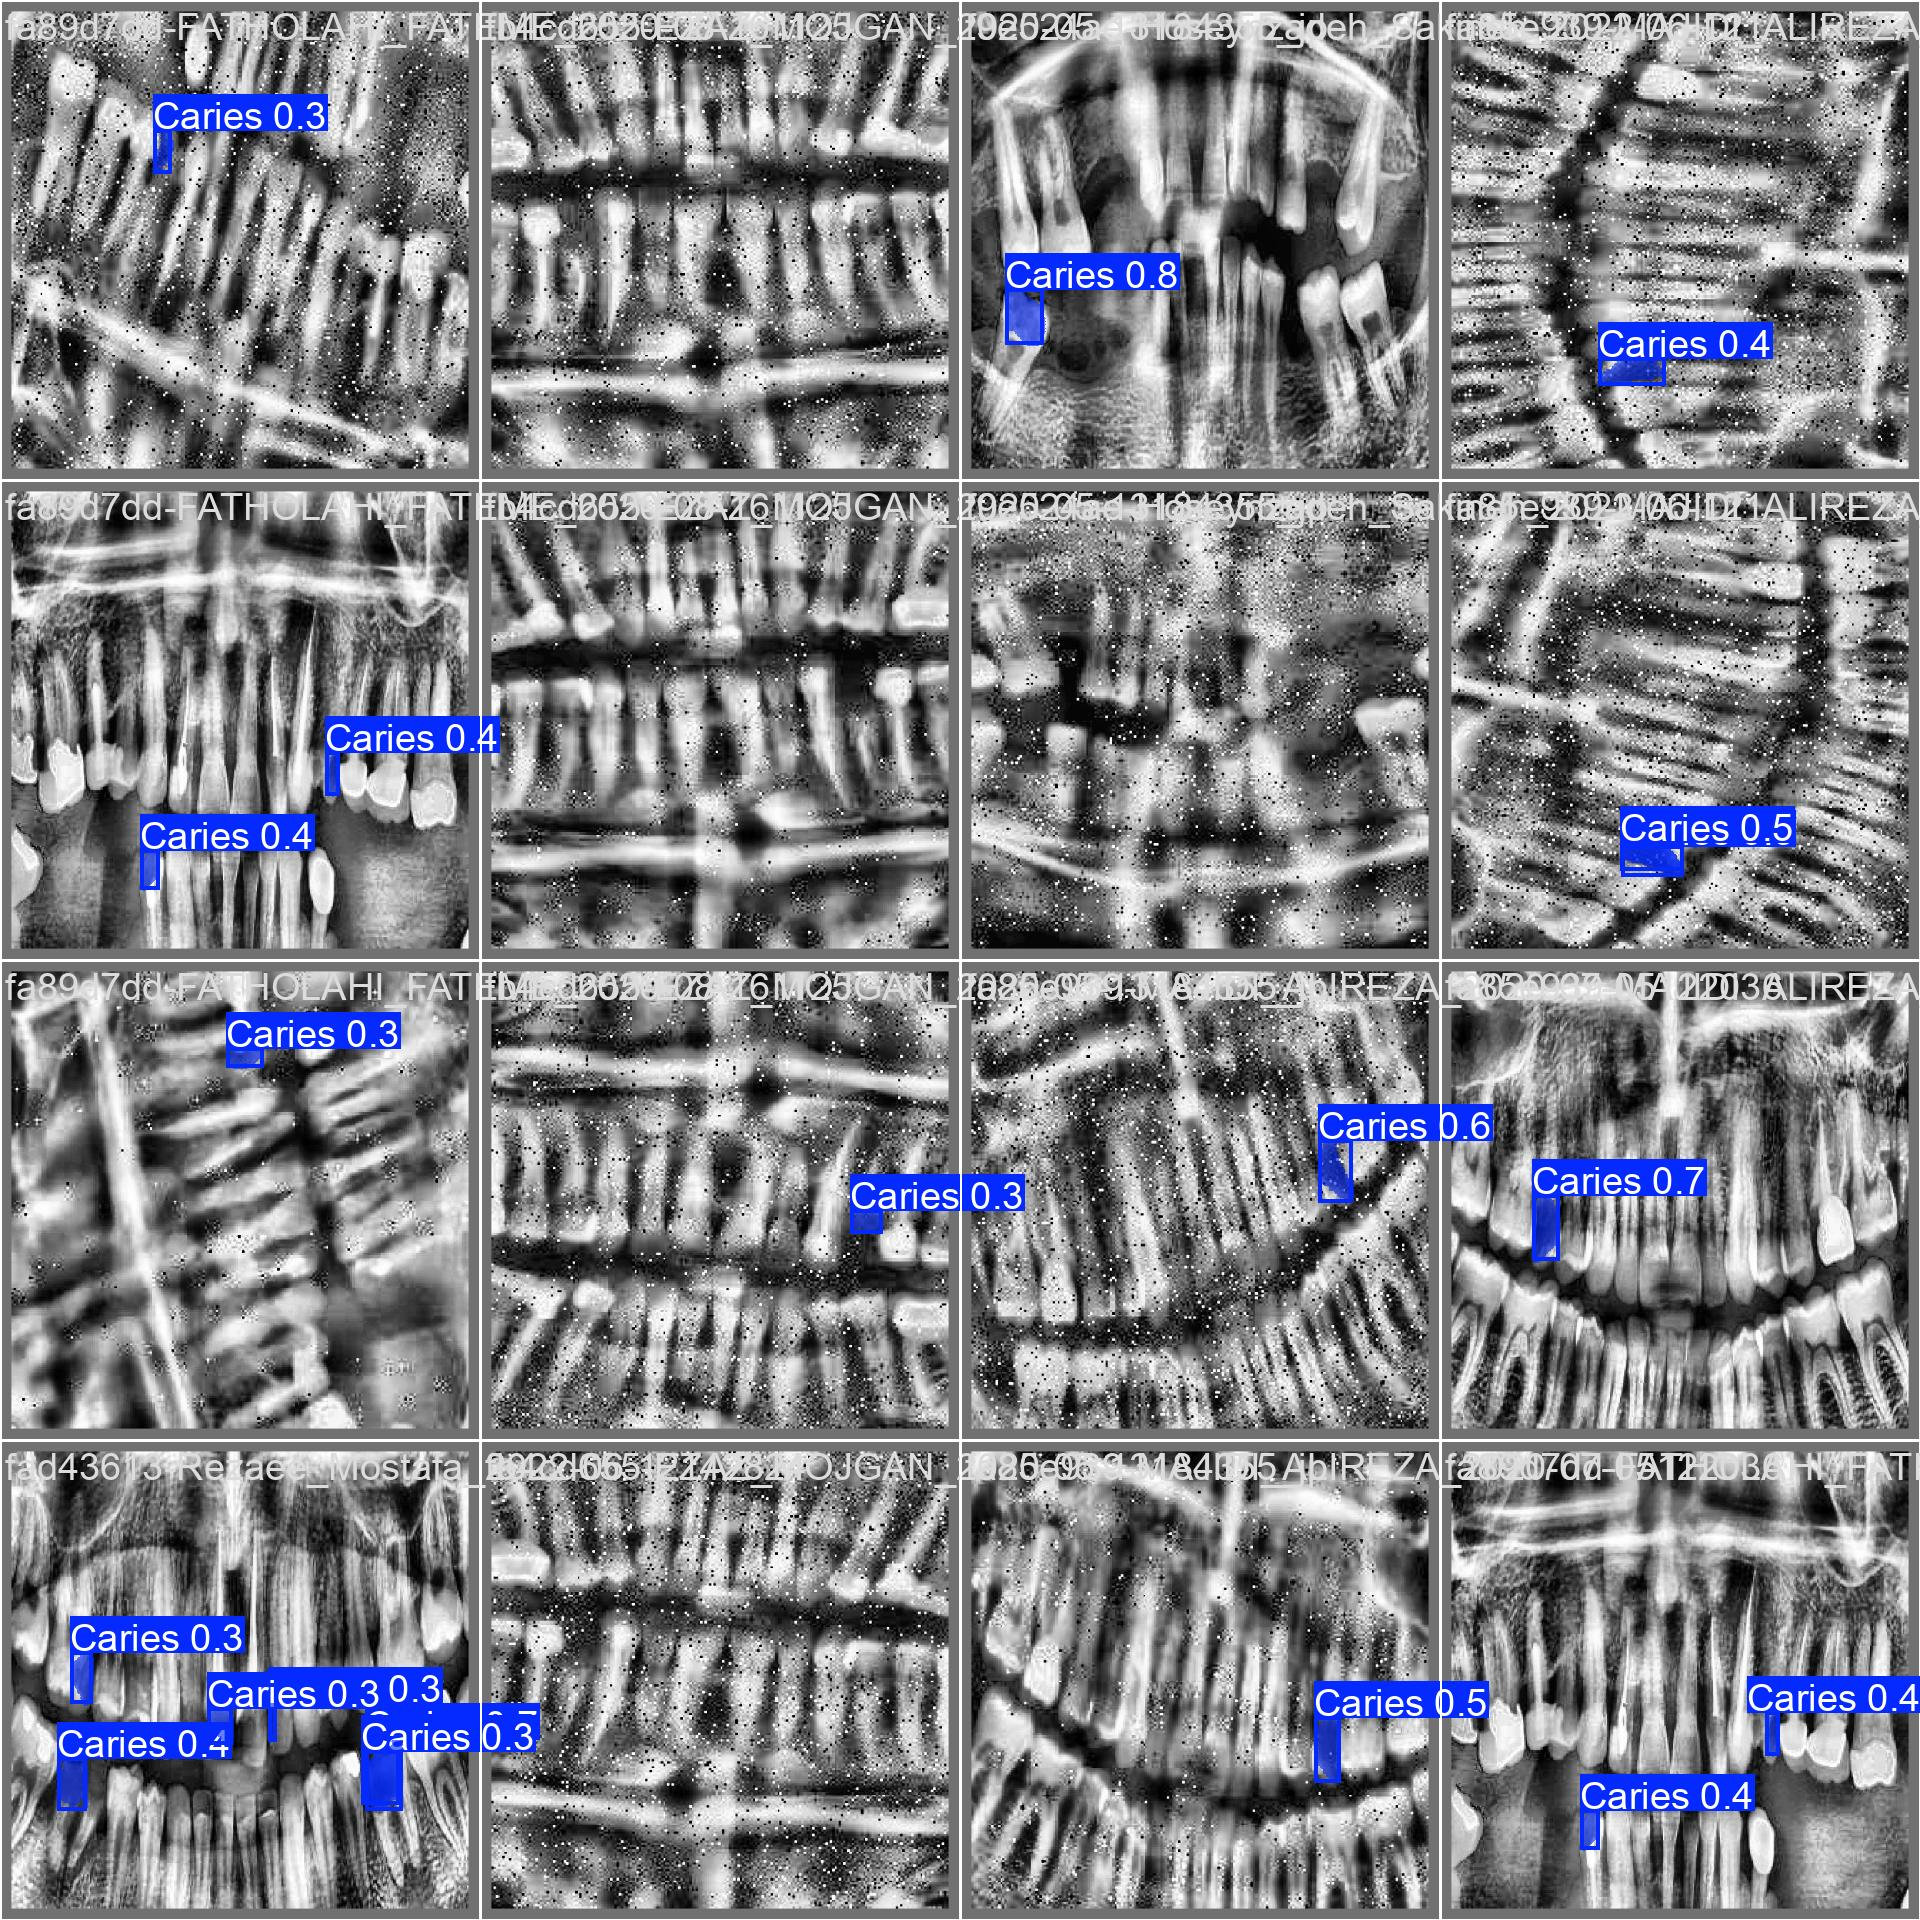

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [10]:
!yolo task=detect mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /content/datasets/Caries-2/valid/labels.cache... 1716 images, 197 backgrounds, 0 corrupt: 100% 1716/1716 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 108/108 [00:32<00:00,  3.29it/s]
                   all       1716       6540      0.421      0.276      0.274        0.1      0.384      0.258      0.245     0.0817
Speed: 0.5ms preprocess, 11.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [11]:
!yolo task=detect mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs

image 1/396 /content/datasets/Caries-2/test/images/0003_jpg.rf.f7c313fc08f26afae2fdcd7e04b973ce.jpg: 640x640 (no detections), 20.2ms
image 2/396 /content/datasets/Caries-2/test/images/000dc27f-NAJIB_MARDANLOO_MASUME_2020-07-12185357_jpg.rf.24e4c891a19cd0871b043378e2d73da1.jpg: 640x640 1 Caries, 20.2ms
image 3/396 /content/datasets/Caries-2/test/images/000dc27f-NAJIB_MARDANLOO_MASUME_2020-07-12185357_jpg.rf.71d1da7365cd7767a0b78ecc0181292a.jpg: 640x640 1 Caries, 20.2ms
image 4/396 /content/datasets/Caries-2/test/images/003e5f80-MOHAMADI_ATEFEH_2020-06-01173808_jpg.rf.d4b9f7c376fe8b1f62084f3a4677e292.jpg: 640x640 1 Caries, 20.2ms
image 5/396 /content/datasets/Caries-2/test/images/

**NOTE:** Let's take a look at few results.

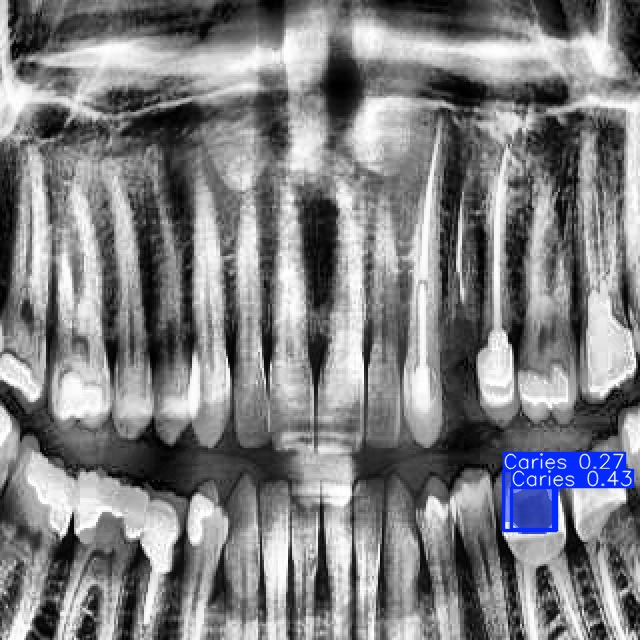

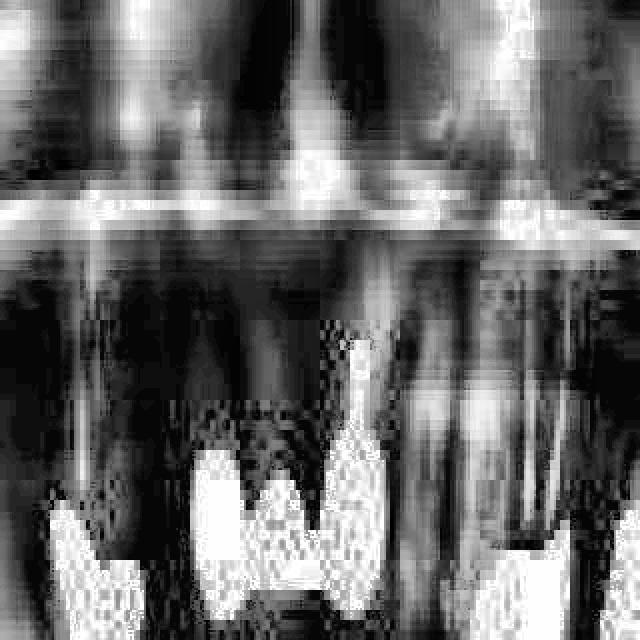

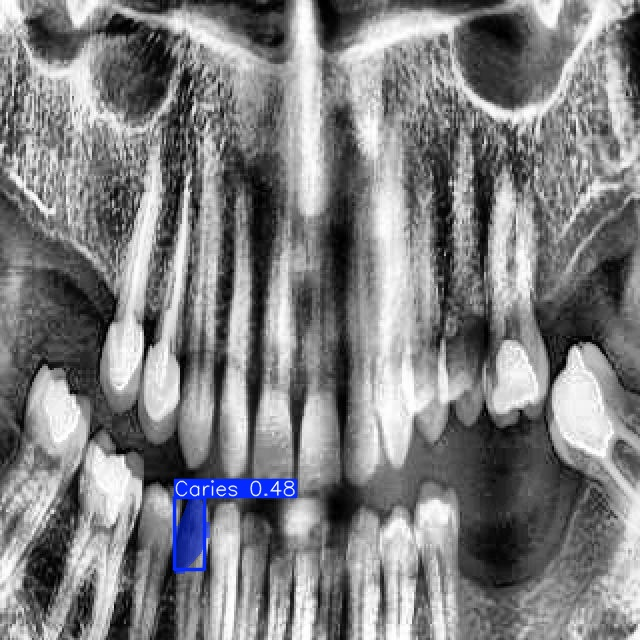

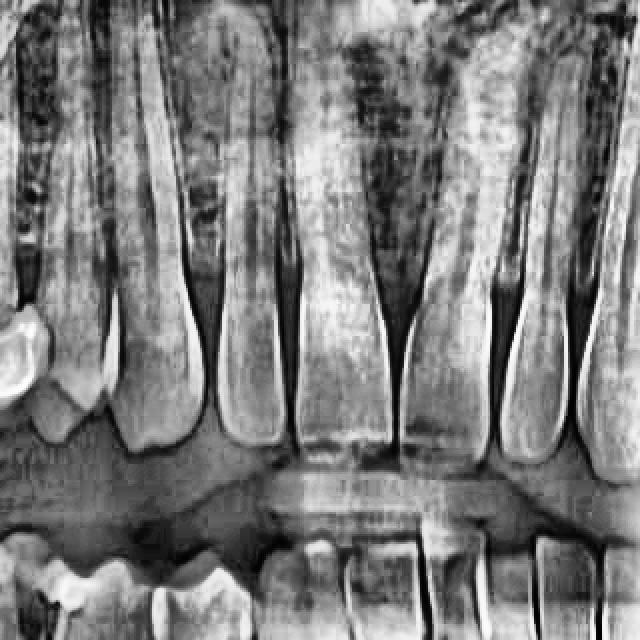

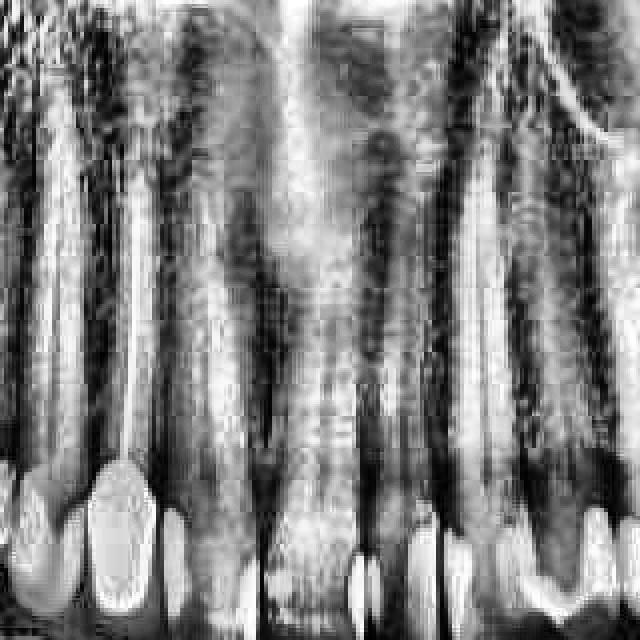

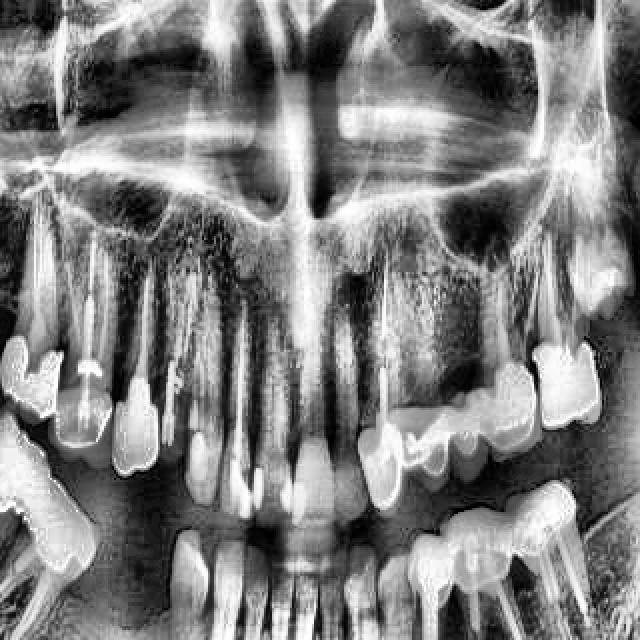

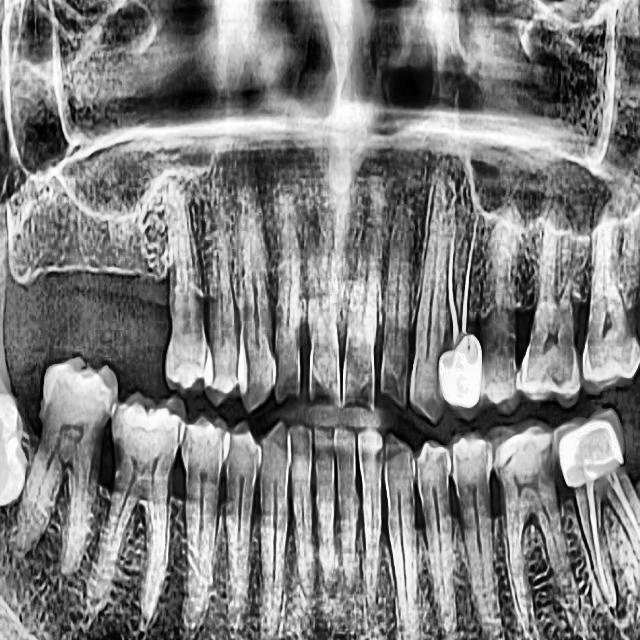

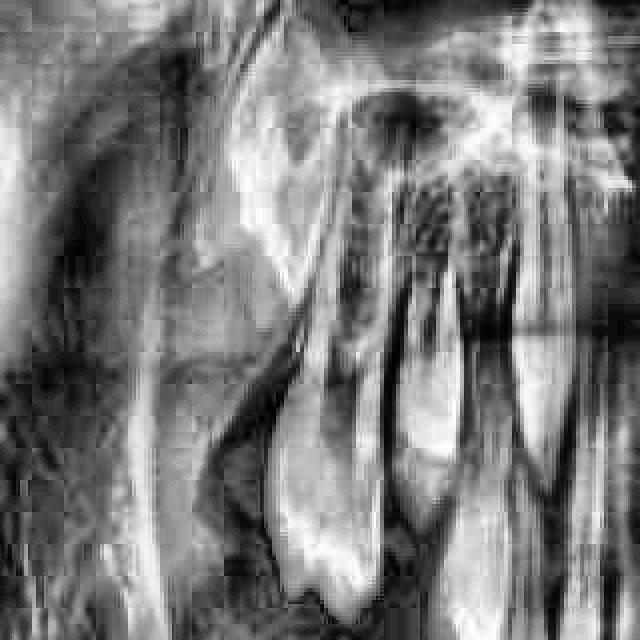

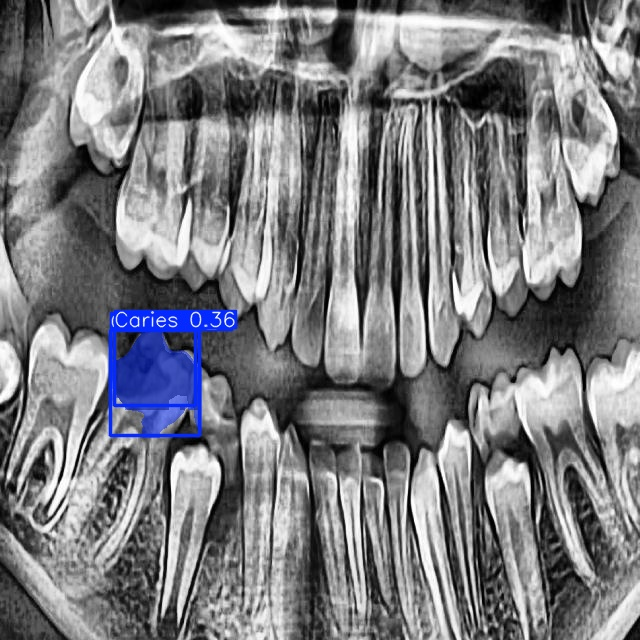

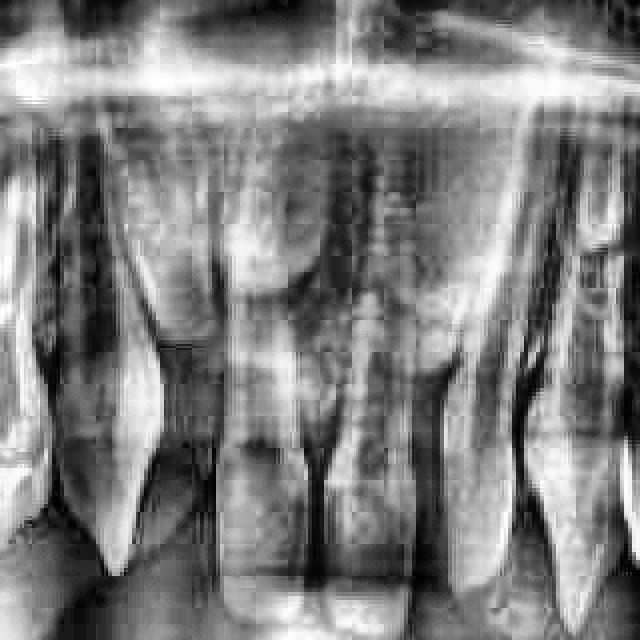

In [13]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:10]:
    display(IPyImage(filename=img, width=600))
    print("\n")